# Cats-v-dogs

In [0]:
# Run the following code to check RAM alloted on a colab session before running any other cell

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

## Loading pretrained weights

In [0]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras import layers
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


from tensorflow.keras.applications.inception_v3 import InceptionV3
from shutil import copyfile
  
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


--2019-08-21 15:29:56--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   113MB/s    in 0.7s    

2019-08-21 15:29:57 (113 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

##Loading the dataset

In [0]:
# # This code block downloads the FULL Cats-v-Dogs dataset and stores it as 
# # cats-and-dogs.zip. It then unzips it to /tmp
# # which will create a tmp/PetImages directory containing subdirectories
# # called 'Cat' and 'Dog' (that's how the original researchers structured it)
# # If the URL doesn't work, 
# # .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# # And right click on the 'Download Manually' link to get a new URL

# !wget --no-check-certificate \
#     "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
#     -O "/tmp/cats-and-dogs.zip"

# local_zip = '/tmp/cats-and-dogs.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()


In [0]:
# Filtered small dataset

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip
  
local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

--2019-08-21 15:29:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  45.5MB/s    in 1.4s    

2019-08-21 15:30:00 (45.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Preprocessing Full dataset

In [0]:
# print(len(os.listdir('/tmp/PetImages/Cat/')))
# print(len(os.listdir('/tmp/PetImages/Dog/')))

In [0]:
# # Making Directories 
# try:
#   os.mkdir("/tmp/cats-v-dogs")
#   os.mkdir("/tmp/cats-v-dogs/training")
#   os.mkdir("/tmp/cats-v-dogs/testing")
#   os.mkdir("/tmp/cats-v-dogs/training/cats")
#   os.mkdir("/tmp/cats-v-dogs/training/dogs")
#   os.mkdir("/tmp/cats-v-dogs/testing/cats")
#   os.mkdir("/tmp/cats-v-dogs/testing/dogs") 
# except OSError:
#     pass

In [0]:
# # Splitting dataset into training and validation sets 

# def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
#   count = 0
#   all_images = os.listdir(SOURCE)
#   valid_images = []
#   for im in all_images:
#     im_path = os.path.join(SOURCE, im)
#     if (os.path.getsize(im_path) != 0):
#       valid_images.append(im)
#     else:
#       print ("Ignoring Empty File: \n", im)   
#   n_train_images = int(SPLIT_SIZE * len(valid_images))
  
#   randomized_images = random.sample(valid_images, len(valid_images))

#   for im in randomized_images[:n_train_images]:
#     im_source = os.path.join(SOURCE, im)
#     im_dest = os.path.join(TRAINING, im)
#     copyfile(im_source, im_dest)
#   for im in randomized_images[n_train_images:]:
#     im_source = os.path.join(SOURCE, im)
#     im_dest = os.path.join(TESTING, im)
#     copyfile(im_source, im_dest)


# CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
# TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
# TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
# DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
# TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
# TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

# split_size = .9
# split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
# split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [0]:
# # To delete a directory
# import shutil
# shutil.rmtree("/tmp/cats-v-dogs")

In [0]:
# print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
# print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
# print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
# print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


## Model Definition

In [0]:
# # Without Pretrained Weights

# model = tf.keras.models.Sequential([

#           tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)),
#           tf.keras.layers.MaxPooling2D(2,2),
#           tf.keras.layers.Dropout(0.2),

#           tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
#           tf.keras.layers.MaxPooling2D(2,2),

#           tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
#           tf.keras.layers.MaxPooling2D(2,2),
#           tf.keras.layers.Dropout(0.2),

#           tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
#           tf.keras.layers.MaxPooling2D(2,2),
#           tf.keras.layers.Dropout(0.2),

#           tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
#           tf.keras.layers.MaxPooling2D(2,2),

#           tf.keras.layers.Flatten(),
#           tf.keras.layers.Dense(1024, activation = 'relu'),
#           tf.keras.layers.Dropout(0.5),
#           tf.keras.layers.Dense(1, activation = 'sigmoid')
# ])
# model.summary()
# model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 64)       

In [0]:
# Using transfer learning

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


W0821 15:30:13.546643 140485933332352 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


last layer output shape:  (None, 7, 7, 768)


In [0]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr = 0.001), loss = 'binary_crossentropy', metrics = ['acc'] )

W0821 15:30:24.858541 140485933332352 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# TRAINING_DIR = "/tmp/cats-v-dogs/training"
# train_datagen = ImageDataGenerator(rotation_range=10,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest')
# train_generator = train_datagen.flow_from_directory(
#                     TRAINING_DIR,
#                     batch_size = 64,
#                     class_mode = 'binary',
#                     target_size =(150, 150))

# VALIDATION_DIR = "/tmp/cats-v-dogs/testing"
# validation_datagen = ImageDataGenerator(rescale = 1.0/255.0)
# validation_generator = validation_datagen.flow_from_directory(
#                     VALIDATION_DIR,
#                     batch_size = 64,
#                     class_mode = 'binary',
#                     target_size =(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Model Training

In [0]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 23s - loss: 0.9386 - acc: 0.7425 - val_loss: 0.9904 - val_acc: 0.8260
Epoch 2/20
100/100 - 17s - loss: 0.4216 - acc: 0.8155 - val_loss: 0.5707 - val_acc: 0.8980
Epoch 3/20
100/100 - 17s - loss: 0.3560 - acc: 0.8430 - val_loss: 0.3898 - val_acc: 0.9370
Epoch 4/20
100/100 - 17s - loss: 0.3865 - acc: 0.8440 - val_loss: 0.4776 - val_acc: 0.9260
Epoch 5/20
100/100 - 17s - loss: 0.3442 - acc: 0.8565 - val_loss: 1.2414 - val_acc: 0.8630
Epoch 6/20
100/100 - 17s - loss: 0.3323 - acc: 0.8590 - val_loss: 0.8153 - val_acc: 0.9090
Epoch 7/20
100/100 - 17s - loss: 0.3280 - acc: 0.8600 - val_loss: 0.6516 - val_acc: 0.9200
Epoch 8/20
100/100 - 17s - loss: 0.3074 - acc: 0.8670 - val_loss: 0.4435 - val_acc: 0.9330
Epoch 9/20
100/100 - 16s - loss: 0.2779 - acc: 0.8805 - val_loss: 0.3723 - val_acc: 0.9440
Epoch 10/20
100/100 - 16s - loss: 0.2990 - acc: 0.8755 - val_loss: 0.9492 - val_acc: 0.8920
Epoch 11/20
100/100 - 17s - loss: 0.2837 - acc: 0.8850 - val_loss: 0.7574 - val_acc: 0.91

In [0]:
# '''
#  When loading the images, you might get warnings about EXIF data being missing or corrupt. 
#  Don't worry about this - it is missing data in the images, but it's not visual data that will impact the training.
# '''

# history = model.fit_generator(train_generator,
#                               epochs=30,
#                               verbose=1,
#                               validation_data=validation_generator)

# # The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# # i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

## Evaluation

Text(0.5, 1.0, 'Training and validation loss')

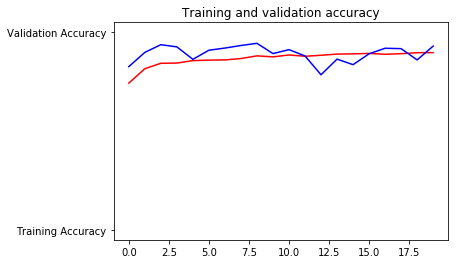

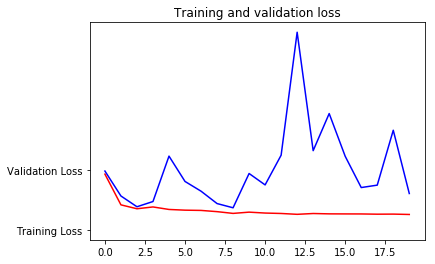

In [0]:
# Plotting loss and accuracies
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')


In [0]:
# # Here's a codeblock just for fun. You should be able to upload an image here 
# # and have it classified without crashing

# import numpy as np
# from google.colab import files
# from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
 
#   # predicting images
#   path = '/content/' + fn
#   img = image.load_img(path, target_size=(# YOUR CODE HERE))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)
#   print(classes[0])
#   if classes[0]>0.5:
#     print(fn + " is a dog")
#   else:
#     print(fn + " is a cat")

In [0]:
# # Before running the next exercise, run the following cell to terminate the kernel and free memory resources:
# import os, signal

# os.kill(     os.getpid() , 
#          signal.SIGKILL
#        )